<h1 align="center">PREDICTING ANIMAL OUTCOMES</h1>

<h3 align="center">Travis Lemon & John Bonfardeci</h3>
<h3 align="center">ISTM 601 Team Project</h3>
<h3 align="center">April 22, 2018</h3>

<br><br><br>


<img src="https://raw.githubusercontent.com/jbonfardeci/austin-animal-shelter-model/master/aas_header.png" alt="Austin Animal Center" />

### ABSTRACT

This paper seeks to improve and/or better understand the outcomes for sheltered animals in the Austin Animal Center. Ultimately, with the use of Python, we aim to predict the outcome for each animal (adopted or not adopted). This information could help the shelter better understand trends in animal outcomes and create effective plans of action. 

We are using a dataset provide by the Austin Animal Center. This particular dataset includes the following information: Animal ID, Name, Data/Time, Outcome Type, Outcome Subtype, Animal Type, Sex, Age, Breed, Color for each animal taken-in by the shelter. 

We will begin the mining process by exploring the data, understating observations and variables, identifying missing values, and overall prepping and cleaning the data. Then, we focus our efforts on analyzing the data by determining trends and relationships, interactions, and distributions.

Once the data are cleaned and prepped, we will fit models with Linear Discriminant Analysys and Logistic Regression to compare models, and to predict the outcome of specific animals. This paper will further outline the process, code, challenges, exploration, and conclusions therein. 


### METHODS AND APPROACH

In order to organize our approach, we generally used the following five phases to execute our objective: 1) Business Understanding; 2) Data Understanding; 3) Data Preparation; 4) Modeling; 5) Evaluation and Comparison.

We began by researching the business to better understand the mission and goals of the Austin Animal Center. It became clear that they were most concerned about the care and wellbeing for all animals in their custody. More specifically, they were keen to better understand the details surrounding animal outcomes (adopted or euthanized).

Our team was able to procure a public dataset provided by the Austin Animal Center. In an effort to better understand this data, we began exploring its contents. By importing ‘Pandas’, we were able to run summary statistics, counts, means, and data types. In further sections we will outline specific libraries, functions and codes used to provide such details.

After reviewing and exploring the data, we realized that data preparation was essential to conducting statistical analysis. Therefore, we created new/additional columns to be used in our analysis as well as reorganized existing information. We also created numerical data as most was only in categorical (object) format. The data cleaning/preparing phase was imperative to building a successful model.  

With respect to modeling, we chose to build and run two types of models using Python, 1) Linear Discriminant Analysis (LDA) w/ 5-fold cross validation, and; 2) Logistic Regression with 5-fold cross validation. We chose these two models based on their ability and power to predict binary outcomes. Furthermore, we used ROC curves and Confusion Matrices to further demonstrate the accuracy (or lack thereof) within each model.

The manner in which we coded and built our models, allowed us to easily evaluate and compare the results. Each of these models we created an ROC curve and Confusion Matrix, which was the basis of comparison. Our goal was to predict adoptions (binary outcome), 1 = success and 0 = failure, so naturally, we were focused on the True Positive Rate (TPR) as the primary indicator for model performance. We even took the evaluation and comparison a step further by building a similar model in JMP. This allowed us to further verify our success in Python.  

### PROBLEMS AND CHALLENGES 

This first problem we experienced, like most datasets, is that there were missing values throughout.  We determined that in this dataset, the values which were missing were minimal. Thus, in addressing this problem, we decided to drop all missing and/or NA values. We did this by adding the df = df.dropna() command when bringing in the model. This can be seen in Figure 4.0 on line 15. 

The next challenge we encountered was the lack of a binary target variable (i.e. 1 and 0) indicating adopted or not adopted. Since our project is based on predicting a binary outcome, we decided to add a column for this variable in our dataset. We simply used Python code to add a 1 for adopted and 0 for note adopted. This was important to address as this column will be our target and/or predicted variable.

Finally, we felt the original column groups were not conducive for accurately predicting animal outcomes. This led to us re-working and re-grouping some of the information within the dataset. The original dataset included a single column for the animals age. Here we decided to split the data into age ranges, for example: `AgeRange _0, AgeRange_1_4, AgeRange_10_15, AgeRange_15_20`. This would allow us to more precisely pin point a particular age group to associate with our predictions. Next, we noticed the original dataset included a single column for "Animal Type" - cat or dog. When class columns with binary categories such as cat/dog, male/female, etc, are converted into indicator variables, by default data science libraries incorrectly create two indicator (a.k.a. dummy) columns. This is incorrect. We created a single column where 1 = Cat and 0 = Dog.



### DATA EXPLORATION AND STATISTICAL ANALYSIS

As shown in Figure 1.0, we start the data exploration and analysis process in Python by initializing our global parameters and/or variables. The initialization of these parameters and/or variables will be the constants throughout our analysis. This will also enable us to make impactful changes and/or switch between variables without amending the individual code, functions or subsets.

As shown in Figure 1.1, we are importing all of the data science, analysis, and data visualization libraries. Libraries such as ‘Panda’ and ‘Numpy’ will allow us to address missing values, add/delete columns, and enhance our mathematical calculations. Another important library we are importing is ‘Statmodels’ which will enable us to build and test models, as well as aid in data exploration process. 

In Figure 2.0, we created a function to import the data, the first function is establishing a file path and verifying that the prescribed file path is valid.

In Figure 3.0 of the Explore section, we begin to review and explore the original dataset to better understand the available variables, size or number of observations, and data types contained in the initial file. We used a simple histograms for each variable.

This summary helped us understand a few characteristics about the data: 1) 26,729 observations; 2) 10 columns or variables; 3) all of the variables are non-numeric.  Figure 4.0 shows a sample of the dataset after cleaning, manipulating and recategorizing some of the columns/variables.

Then, as shown in Figure 4.1 under the Modify section, we define a function to display and estimate the OLS predictor coefficients for the model. The output from this function is shown in Figure 4.1 as well. This function and analysis are setting up the data for variable selection. For our particular model, variable selection is very important as it prevents against overfitting, simplification and/or model efficiency, and to avoid potential multiple dimensionality within the data. Thus, as shown in Figure 4.1, we created a function to execute Lasso selection based on the earlier predictor coefficient estimates. Also, included in Figure 4.1 is a function to remove/drop any insignificant variables as identified by the preceding lasso analysis. Figure 4.1 also resembles the results from the Lasso method, thereby only showing the significant variables to be used in further analysis.

In Figure 5.0 under the Model & Assess section, we created a robust function to run Linear Discriminant Analysis (LDA) with 5-fold cross validation, and best probability threshold according to Balanced Accuracy formula. Within this function, we are setting local parameters, identifying cross validation specifications, and are evenly spacing numbers over specified intervals. However, most importantly, we are splitting the data in to train and test, calling on previously created ROC functions and Confusion Matrices functions for this analysis. Figure 5.0 also displays the results from the ROC command, and in this graph, it includes Specificity and Sensitivity of the prescribed 5-fold cross validation. Also in Figure 5.0, we see the Confusion Matrix for LDA analysis, which indicates a true positive (TPR) of 87.3% and true negative rate (TNR) of 63.0%.

In Figure 5.1 we created a robust Logistic Regression function with 5-fold cross validation, and best probability threshold according to Balanced Accuracy formula. Similar to the LDA function, the logistic regression function sets local parameters, identify cross validation specifications, and are evenly spacing numbers over specified intervals. Included in the function is also the mechanism to split the data into train and test. This function also calls on previously created ROC and Confusion Matrices functions for this analysis. Also, Figure 5.1 displays the results from the ROC command, and in this graph, it includes Specificity and Sensitivity of the prescribed 5-fold cross validation. Also in Figure 5.1, we see the Confusion Matrix for Logistic Regression analysis, which indicates a true positive (TPR) of 87.2% and true negative rate (TNR) of 63.1%.


### INTERPRETATION AND CONCLUSIONS

As stated previously, and throughout this paper, our analysis focused on using Python for Logistic Regression and Linear Discriminant Analysis (LDA) to predict animal outcome from Austin Animal Center. Upon conclusion of our analysis it appears that our LDA model slightly outperformed our Logit model in Python as far as predicting adoptions (TPR). As stated, we took this analysis a step further by creating a Logistic Regression model in JMP, so we could further validate and compare our results. Figure 6.0 displays the ROC curve and Confusion Metrix from the JMP Logistic Regression model. The Sensitivity (TPR) in the JMP model is 70.72% compared with ~87% in both the Python LDA and Logit models. However the true negative rate (1-FPR) is 78.5% in the JMP model and ~63% in both the Python LDA and Logit models. The AUC is about the same in all models ~ 0.83 

It turns out that our Python models outperform the JMP model as far as adoptions (TPR), since our goal was to predict adoptions where 1 = success. The LDA TPR was the highest out of all the models: 87.27 (LDA) vs. 87.23% (Logit) and 70.72% (JMP Logit). 

We attribute the slightly better results in the LDA model compared to the Logit model to providing prior estimates to the `priors` option of the LDA class. The priors were estimated with the Gaussian Naive Bayes class.

The JMP true-negative rate (TNR) was higher than the either of the Python models. Thus, one could also predict non-adoptions at a reasonable rate with the JMP model. However, the TPR for the Python models is still higher than the TNR rate obtained with the JMP model.

The advantages with the Python models are that we could utilize 5-fold cross validation to split the training data into 80/20, train/validate sets to obtain a more realistic mean TPR and TNR. This also meant we could test the entire dataset rather than throwing away precious data as with the traditional 70/30 train/validation split approach. 

We were also able to select the most optimal probability threshold/cutoff with custom functions. For the LDA model, the optimal cuttoff was 0.392 whereas in JMP, the default cutoff is 0.5. It is not possible to change this setting in JMP.

The final interpretation and conclusions based on our Python models and coefficients (Figure 4.3), are that people prefer cats. They prefer animals that have been spayed or neutered and are relatively new born, between the age range of 0 – 1 year old. It appears that most of the colors had a slightly negative impact. Also, what is clear by this analysis is that people do not prefer mixed breeds or animals greater than 10yrs old.

<h2 align="center">APPENDIX</h2>
<br><br>

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Balanced Accuracy)
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Balanced Accuracy)
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

All of the links below proved helpful in the researh for writing this notebook.
* http://sebastianraschka.com/Articles/2014_python_lda.html#introduction
* http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
* https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* https://en.wikipedia.org/wiki/Youden%27s_J_statistic
* http://stats.stackexchange.com/questions/29719/how-to-determine-best-cutoff-point-and-its-confidence-interval-using-roc-curve-i
* https://sasshowcase.wordpress.com/category/sas-macro/
* http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://www.medcalc.org/manual/roc-curves.php
* http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
* http://www.umich.edu/~ners580/ners-bioe_481/lectures/pdfs/1978-10-semNucMed_Metz-basicROC.pdf
* http://scikit-learn.org/stable/modules/cross_validation.html
* http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* http://gim.unmc.edu/dxtests/roc2.htm
* https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
* http://scikit-learn.org/stable/modules/feature_selection.html

### Figure 1.0 - Global variables

In [1]:
# Change These Parameters

# relative file path; can place in same working directory as notebook
FILE_PATH = 'animal_shelter_train.csv'

# name of target column
TARGET_NAME = 'Adopted'

# Name of Key/ID column
KEY_NAME='AnimalID'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
TARGET_VALUE = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
LDA_SOLVER = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
LDA_SHRINKAGE = 'auto'

# number of cross-validation groups to run
NUM_CV = 5

# Saving output
SAVE_FIGS = True
OUTPUT_TO_CSV = True
OUTPUT_DIR = 'output/'

# Define global vars
X = None # Matrix of variables
y = None # Dependent variable list
keys = None # Key/ID values
columns = None # Names of variables
df_raw = None # Pandas DataFrame for raw imported data.
df = None # Pandas DataFrame to store our model data.

### Figure 1.1 - Import External Libraries

In [2]:
#Import Dependent Libraries
# DON'T change below this line unless you know what your're doing.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import math
import pandas as pd
import numpy as np
from scipy import interp
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, SelectFromModel, SelectFpr
from IPython.display import display
import re
import statsmodels.api as sm
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

## Import our custom stat utility class library.

In [3]:
import StatUtilities as u

# Sample

### Figure 2.0 - Import Raw Data

In [4]:
# Import data and display a summary table.
def import_data(file_path):
    """
    Import a CSV file to a Pandas dataframe.
    @param file_path <string>
    @return Pandas Dataframe
    """
    try:
        if not os.path.exists(file_path):
            print('Invalid file path!')
            return None

        df = pd.read_csv(file_path) # returns new Pandas DataFrame 
        return df
    except IOError:
        print('Error reading file ' + file_path)
        return None

if __name__ == '__main__':
    df_raw = import_data('train.csv')
    df_raw = df_raw.drop('DateTime', 1).drop('OutcomeSubtype', 1).drop('AnimalID', 1).drop('Name', 1)
    display(df_raw.describe())

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,26729,26728,26711,26729,26729
unique,5,2,5,44,1380,366
top,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,10769,15595,9779,3969,8810,2824


# Explore

### Figure 3.0 - Univariate Analysis

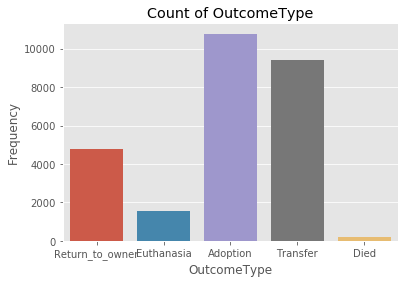

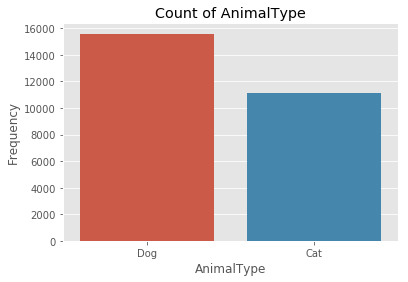

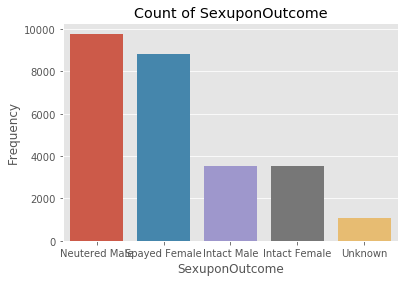

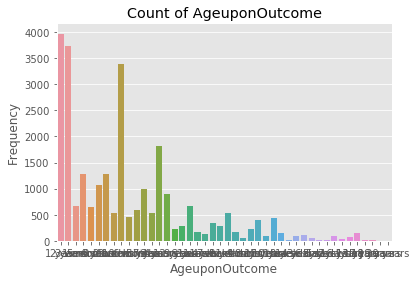

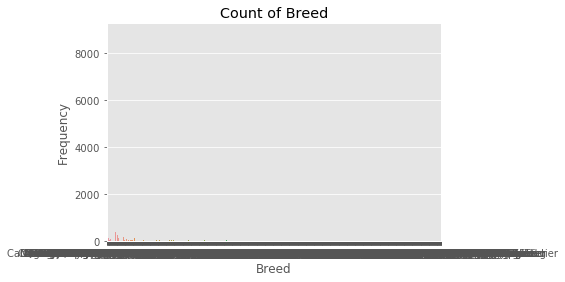

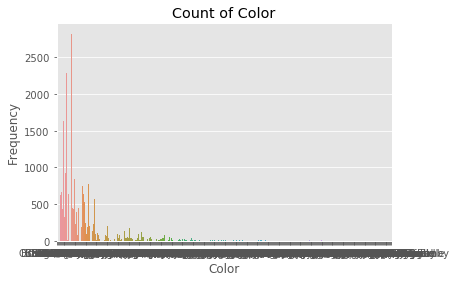

In [5]:
# Create histograms for each variable.
def get_class_plots(df):
    tmp = pd.DataFrame()
    if type(df) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    """
    Display histograms for all the class variables.
    """
    for col in df.columns:
        count, ax = plt.subplots()
        ax = sns.countplot(col, data=df)
        ax.set_title('Count of ' + col)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        plt.show()

if __name__ == '__main__':
    get_class_plots(df_raw)

# Modify

### Figure 4.0 - Transform the Dataset

In [6]:
def transform(dataframe):
    tmp = pd.DataFrame()
    if type(dataframe) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    
    """
    Transform the raw data into usable indicator columns.
    Create new predictors from more concise grouping of categories.
    @param dataframe
    @param target_name
    @returns [y<list>, matrix<list<list>>, dataframe, columns<list>]
    """
    # drop NA
    dataframe = dataframe.dropna()
    #randomize the data
    dataframe = dataframe.iloc[np.random.permutation(len(dataframe))]
    
    matrix = []
    columns = ['Adopted', 'Cat', 'AgeRange_0', 'AgeRange_1_4', 'AgeRange_5_9', 'AgeRange_10_14', 'AgeRange_15_20',
              'SexuponOutcome', 'ColorCat', 'MixBreed']
    
    for index, row in dataframe.iterrows():
        
        # Adopted
        outcome = 1 if row['OutcomeType'] == 'Adoption' else 0
        
        # Cat or Dog
        cat = 1 if row['AnimalType'] == 'Cat' else 0
        
        # Group ages into age categories.
        age_cat = str(row['AgeuponOutcome'])
        age = int(re.sub('\\D+', '', age_cat))
        ageRange_0 = 0
        ageRange_1_4 = 0
        ageRange_5_9 = 0
        ageRange_10_14 = 0 
        ageRange_15_20 = 0
        
        if age_cat.find('months') > -1:
            ageRange_0 = 1
        else:
            ageRange_1_4 = 1 if age >= 1 and age < 5 else 0
            ageRange_5_9 = 1 if age >= 5 and age < 10 else 0
            ageRange_10_14 = 1 if age >= 10 and age < 15 else 0
            ageRange_15_20 = 1 if age >= 15 else 0
        
        sex = row['SexuponOutcome']
        
        # Combine colors that are similar
        colorCat = None
        color = row['Color']
        
        if color == 'White/Black' or color == 'Black/White':
            colorCat = 'Black/White'
        elif color == 'Tan/Black' or color == 'Black/Tan':
            colorCat = 'Black/Tan'
        elif color == 'Brown/Black' or color == 'Black/Brown':
            colorCat = 'Black/Brown'
        elif color == 'White/Blue' or color == 'Blue/White':
            colorCat = 'Blue/White'
        elif color == 'Brown' or color == 'Chocolate' or color == 'Brown Tabby':
            colorCat = 'Brown'
        elif color == 'White/Brown' or color == 'Brown/White':
            colorCat = 'Brown/White'
        elif color == 'White/Tan' or color == 'Tan':
            colorCat = 'Tan'
        elif color == 'Yellow/White' or color.rfind('Yellow') == 0:
            colorCat = 'Yellow'
        elif color.find('White') == 0:
            colorCat = 'White'
        elif color.find('Blue') == 0:
            colorCat = 'Blue'
        elif color.find('Black') == 0:
            colorCat = 'Black'
        elif color.find('Tricolor') == 0:
            colorCat = 'Tricolor'
        elif color.find('Tortie') == 0:
            colorCat = 'Tortie'
        elif color == 'Calico':
            colorCat = 'Calico'
        elif color.find('Red') == 0:
            colroCat = 'Red'
        else:
            colorCat = 'Other'
        
        breed = row['Breed']
        
        # Mix
        mixedBreed = 1 if row['Breed'].lower().find('mix') > -1 else 0

        a = [outcome, cat, ageRange_0, ageRange_1_4, ageRange_5_9, ageRange_10_14, ageRange_15_20, 
             sex, colorCat, mixedBreed]
        
        matrix.append(a)
    # /end for...
        
    df = pd.DataFrame(data=matrix, columns=columns) # Create dataframe
    df = pd.get_dummies(df)
    
    # Clean col names removing special characters
    df.columns = map(lambda c: re.sub('[^a-zA-Z0-9_]', '_', c), df.columns)
    
    # Get list of actual Y outcomes
    y = pd.Series( map(lambda x: 1 if x == 1 else 0, df['Adopted']) ).as_matrix()
    df = df.drop('Adopted', 1) # can't include Y as predictor, drop
    X = df.as_matrix() # Get predictors only
    return [y, X, df, df.columns]
    
if __name__ == '__main__':
    y, X, df, columns = transform(dataframe=df_raw)
    display(df.describe())

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_5_9,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Female,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,...,ColorCat_Blue_White,ColorCat_Brown,ColorCat_Brown_White,ColorCat_Calico,ColorCat_Other,ColorCat_Tan,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,...,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.116099,0.039161,0.005728,0.834145,0.131187,0.131748,0.366118,...,0.031187,0.090116,0.054399,0.019356,0.265219,0.038076,0.022950,0.029951,0.060314,0.009734
std,0.492939,0.463402,0.499334,0.320349,0.193982,0.075469,0.371958,0.337611,0.338223,0.481751,...,0.173826,0.286353,0.226808,0.137776,0.441458,0.191382,0.149748,0.170456,0.238073,0.098182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Figure 4.1 - Get Estmimates Coefficients and P-values

In [7]:
def get_var_estimates(target_name, y, X, columns):
    """
    Show OLS parameter estimates for the model.
    Ref: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html
    @param target_name <string>
    @param y <list>
    @param X <Pandas Dataframe>
    @param columns <list>
    @returns Statsmodel summary
    """
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary(yname=target_name, xname=columns, title='PValues', alpha=0.05)
    
if __name__ == '__main__':
    summary = get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])
    #display(summary)
    #print(dir(summary))
    display(summary)
    # output estimates to CSV
    outfile = open('estimates.csv', 'w')
    outfile.write(summary.tables[1].as_csv())
    outfile.close()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   PValues                                    
==============================================================================
Dep. Variable:                Adopted   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     485.8
Date:                Sat, 21 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:15:30   Log-Likelihood:                -13699.
No. Observations:               26710   AIC:                         2.745e+04
Df Residuals:                   26683   BIC:                         2.767e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Cat                              0.0494      0.007      7.504      0.000       0.037       0.062
AgeRange_0                       0.2263      0.087      2.609      0.009       0.056       0.396
AgeRange_1_4                    -0.0119      0.087     -0.137      0.891      -0.182       0.158
AgeRange_5_9                    -0.1392      0.087     -1.602      0.109      -0.310       0.031
AgeRange_10_14                  -0.1915      0.088     -2.188      0.029      -0.363      -0.020
AgeRange_15_20                  -0.2705      0.093     -2.922      0.003      -0.452      -0.089
MixBreed                        -0.0169      0.007     -2.407      0.016      -0.031      -0.003
SexuponOutcome_Intact_Female    -0.0011      0.088     -0.013      0.990      -0.173       0.171
SexuponOutcome_Intact_Male      -0.0107      0.088     -0.121      0.903      -0.183       0.162
SexuponOutcome_Neutered_Male     0.4803      0.088      5.468      0.000       0.308       0.652
SexuponOutcome_Spayed_Female     0.5305      0.088      6.039      0.000       0.358       0.703
SexuponOutcome_Unknown          -0.0495      0.088     -0.564      0.573      -0.221       0.122
ColorCat_Black                2.096e-05      0.016      0.001      0.999      -0.032       0.032
ColorCat_Black_Brown             0.0444      0.020      2.220      0.026       0.005       0.084
ColorCat_Black_Tan               0.0192      0.019      0.986      0.324      -0.019       0.057
ColorCat_Black_White             0.0054      0.015      0.349      0.727      -0.025       0.036
ColorCat_Blue                    0.0377      0.018      2.100      0.036       0.003       0.073
ColorCat_Blue_White              0.0080      0.020      0.405      0.686      -0.031       0.047
ColorCat_Brown                   0.0060      0.017      0.365      0.715      -0.026       0.038
ColorCat_Brown_White             0.0153      0.017      0.884      0.377      -0.019       0.049
ColorCat_Calico                  0.0043      0.023      0.185      0.853      -0.042       0.050
ColorCat_Other                   0.0137      0.015      0.919      0.358      -0.015       0.043
ColorCat_Tan                     0.0060      0.019      0.322      0.747      -0.031       0.043
ColorCat_Tortie                 -0.0064      0.022     -0.288      0.773      -0.050       0.037
ColorCat_Tricolor                0.0244      0.020      1.231      0.218      -0.014       0.063
ColorCat_White                  -0.0017      0.017     -0.099      0.921      -0.035       0.032
ColorCat_Yellow                 -0.0555      0.029     -1.942      0.052      -0.112       0.001
==============================================================================
Omnibus:                     5049.811   Durbin-Watson:                   2.006
Prob(Omnibus): 

### Figure 4.1 - Variable Selection

Selected significant variables are:
 Cat, AgeRange_0, AgeRange_1_4, AgeRange_10_14, AgeRange_15_20, MixBreed, SexuponOutcome_Intact_Male, SexuponOutcome_Neutered_Male, SexuponOutcome_Spayed_Female, SexuponOutcome_Unknown, ColorCat_Black, ColorCat_Black_Brown, ColorCat_Black_Tan, ColorCat_Blue, ColorCat_Brown_White, ColorCat_Other, ColorCat_Tortie, ColorCat_Tricolor, ColorCat_White, ColorCat_Yellow

Dropped insignificant vars:  AgeRange_5_9, SexuponOutcome_Intact_Female, ColorCat_Black_White, ColorCat_Blue_White, ColorCat_Brown, ColorCat_Calico, ColorCat_Tan


,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,ColorCat_Black,ColorCat_Black_Brown,ColorCat_Black_Tan,ColorCat_Blue,ColorCat_Brown_White,ColorCat_Other,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.039161,0.005728,0.834145,0.131748,0.366118,0.330176,0.040771,0.101423,0.028791,0.032010,0.054062,0.054399,0.265219,0.022950,0.029951,0.060314,0.009734
std,0.492939,0.463402,0.499334,0.193982,0.075469,0.371958,0.338223,0.481751,0.470285,0.197764,0.301893,0.167221,0.176031,0.226145,0.226808,0.441458,0.149748,0.170456,0.238073,0.098182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


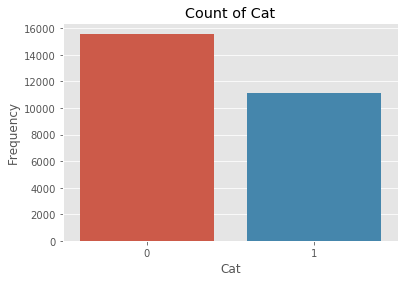

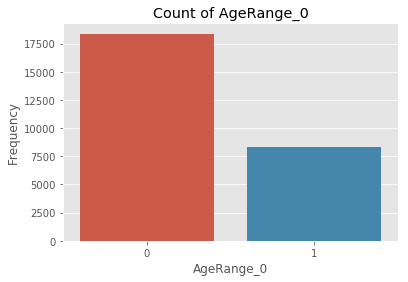

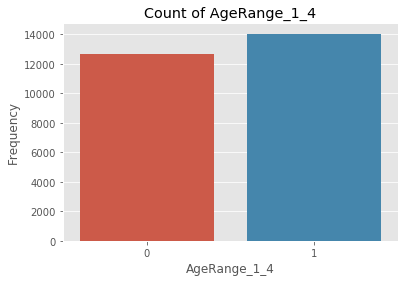

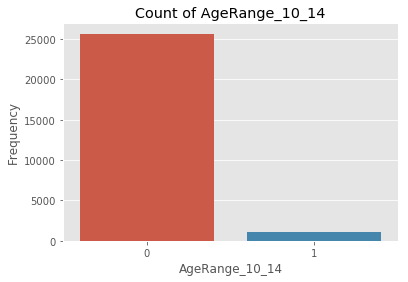

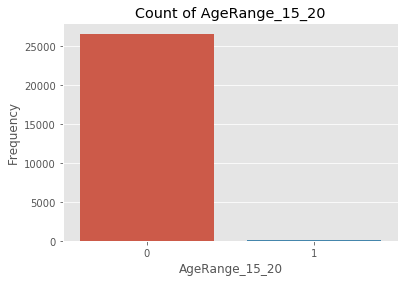

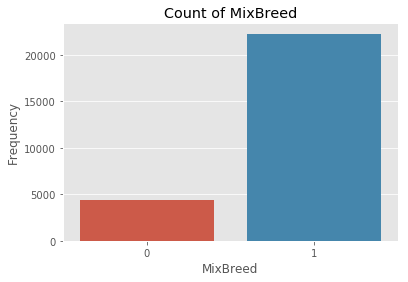

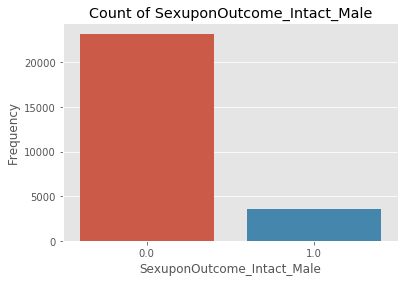

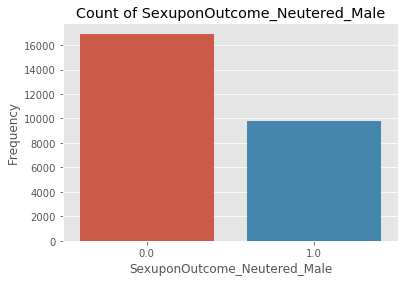

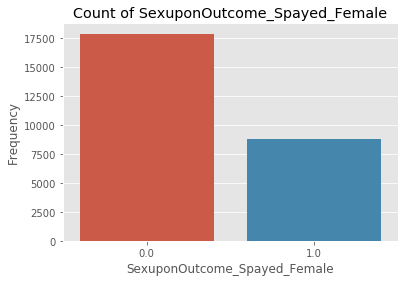

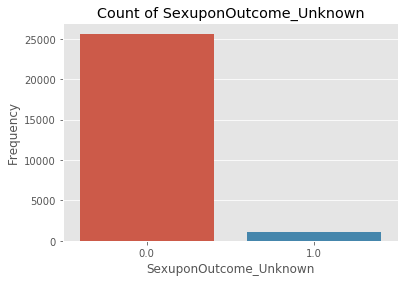

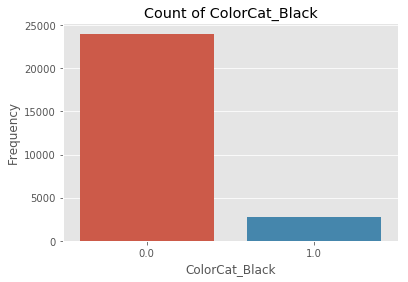

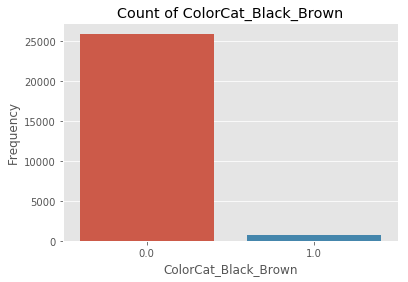

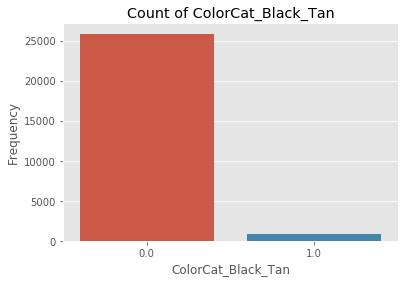

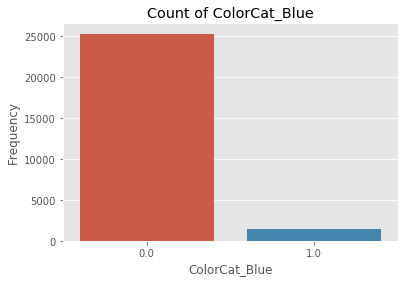

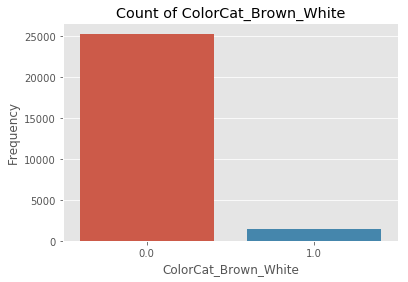

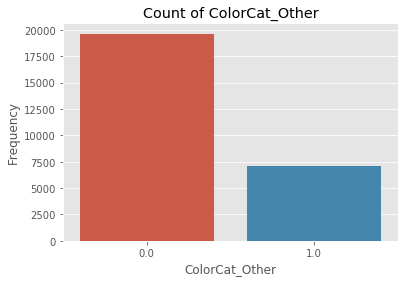

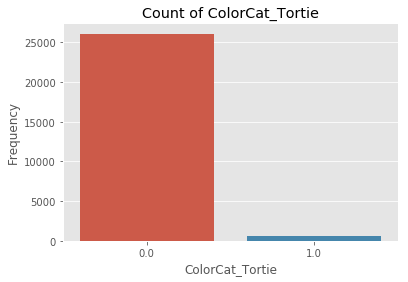

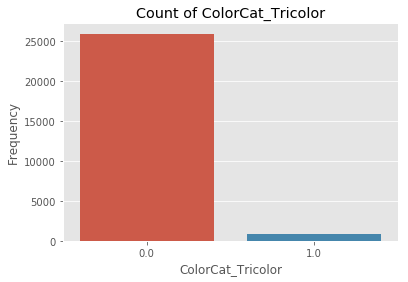

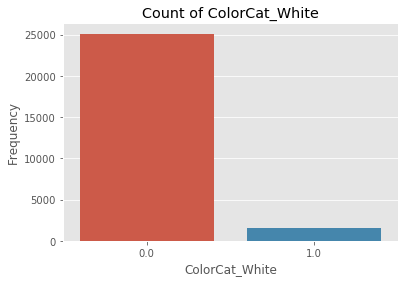

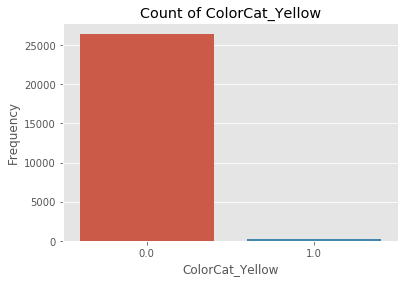

In [8]:
# Lasso feature selection
def get_lasso_selection(X, y, columns):
    """
    Select significant variables according to Lasso.
    Best model is selected by cross-validation.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @returns <list>
    """
    clf = LassoCV(max_iter=10000)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    features = sfm.transform(X).shape[1]
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(columns, feature_indices):
        if b:
            significant_features.append(c)
            
    return significant_features
    
def remove_insignificant_vars(sig_var_list, df):
    """
    Remove insignificant variables from a DataFrame.
    @param sig_var_list <list>
    @param df <DataFrame>
    @returns <DataFrame>
    """
    drop = []
    cols = df.columns.tolist()
    for v in cols:
        if not v in sig_var_list:
            drop.append(v)
            df = df.drop(str(v), 1)
            
       
    print('\r\nDropped insignificant vars: ', ', '.join(drop))
    display(df.describe())
    return df
    
if __name__ == '__main__':
    significant_features = get_lasso_selection(X=X, y=y, columns=columns)
    print('Selected significant variables are:\r\n', ', '.join(significant_features))

    df = remove_insignificant_vars(significant_features, df.copy())
    X = df.as_matrix() 
    columns = df.columns.tolist()
    get_class_plots(df)

### Figure 4.2 - Re-run Estimates After Variable Selection (Adj. R-Square improves)

In [9]:
if __name__ == '__main__':
    summary = get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])
    display(summary)
    # output estimates to CSV
    outfile = open('estimates.csv', 'w')
    outfile.write(summary.tables[1].as_csv())
    outfile.close()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   PValues                                    
==============================================================================
Dep. Variable:                Adopted   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     1945.
Date:                Sat, 21 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:15:36   Log-Likelihood:                -13762.
No. Observations:               26710   AIC:                         2.756e+04
Df Residuals:                   26690   BIC:                         2.773e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Cat                              0.0431      0.006      6.967      0.000       0.031       0.055
AgeRange_0                       0.3184      0.008     41.956      0.000       0.304       0.333
AgeRange_1_4                     0.0755      0.007     11.288      0.000       0.062       0.089
AgeRange_10_14                  -0.1017      0.014     -7.371      0.000      -0.129      -0.075
AgeRange_15_20                  -0.1825      0.033     -5.486      0.000      -0.248      -0.117
MixBreed                        -0.0513      0.006     -8.109      0.000      -0.064      -0.039
SexuponOutcome_Intact_Male      -0.0534      0.009     -6.008      0.000      -0.071      -0.036
SexuponOutcome_Neutered_Male     0.4296      0.007     63.301      0.000       0.416       0.443
SexuponOutcome_Spayed_Female     0.4804      0.007     69.842      0.000       0.467       0.494
SexuponOutcome_Unknown          -0.0850      0.014     -6.139      0.000      -0.112      -0.058
ColorCat_Black                  -0.0190      0.009     -2.148      0.032      -0.036      -0.002
ColorCat_Black_Brown             0.0165      0.015      1.082      0.279      -0.013       0.046
ColorCat_Black_Tan              -0.0064      0.015     -0.436      0.662      -0.035       0.022
ColorCat_Blue                    0.0202      0.012      1.742      0.082      -0.003       0.043
ColorCat_Brown_White            -0.0100      0.012     -0.869      0.385      -0.033       0.013
ColorCat_Other                  -0.0062      0.006     -0.988      0.323      -0.019       0.006
ColorCat_Tortie                 -0.0275      0.017     -1.584      0.113      -0.062       0.007
ColorCat_Tricolor               -0.0038      0.015     -0.257      0.797      -0.033       0.026
ColorCat_White                  -0.0269      0.011     -2.480      0.013      -0.048      -0.006
ColorCat_Yellow                 -0.0809      0.026     -3.170      0.002      -0.131      -0.031
==============================================================================
Omnibus:                     7627.074   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1206.518
Skew:                          -0.030   Prob(JB):                    1.02e-262
Kurtosis:                       1.961   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 4.3 - Display Selected Variable Effects

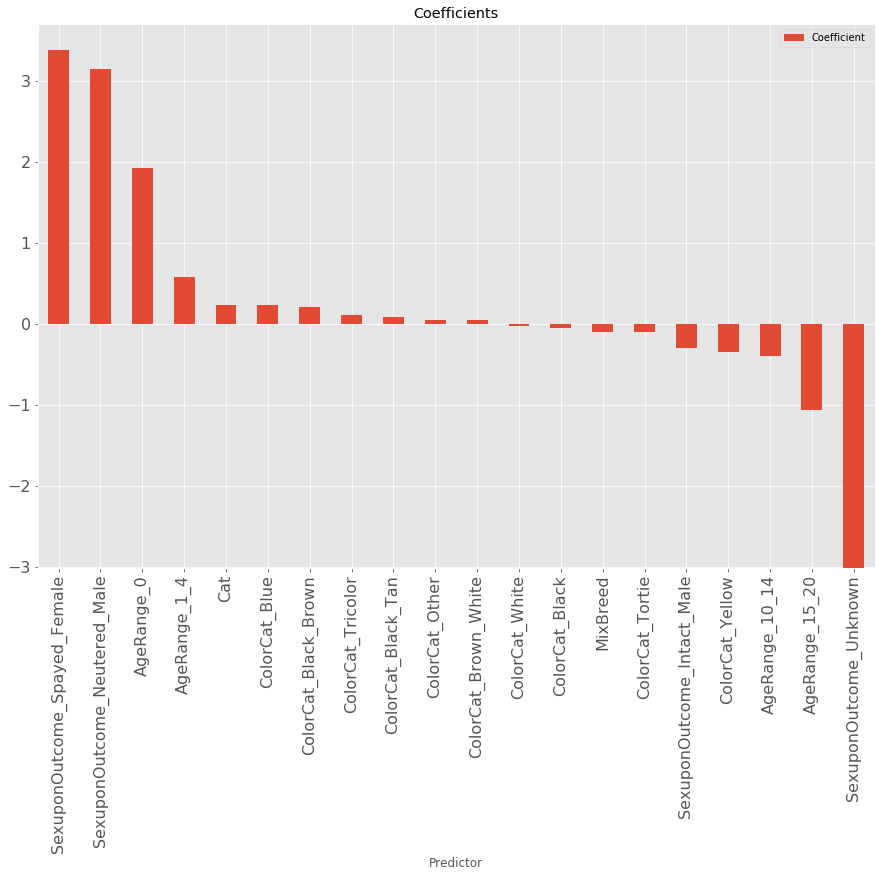

,Predictor,Coefficient
8,SexuponOutcome_Spayed_Female,3.383647
7,SexuponOutcome_Neutered_Male,3.150890
1,AgeRange_0,1.921576
2,AgeRange_1_4,0.580470
0,Cat,0.242290
13,ColorCat_Blue,0.238830
11,ColorCat_Black_Brown,0.208737
17,ColorCat_Tricolor,0.107952
12,ColorCat_Black_Tan,0.091824
15,ColorCat_Other,0.054612


In [10]:
def display_coeff(columns, X, y):
    """
    Display estimated coefficients as bar chart and table.
    @returns void
    """
    logit = LogisticRegression()
    logit.fit(X, y)

    est_col = []
    for col, coef in zip(df.columns, logit.coef_[0]):
        est_col.append([col, coef])

    df_est = pd.DataFrame(data=est_col, columns=['Predictor', 'Coefficient'])
    df_est = df_est.sort_values('Coefficient', ascending=False)

    # plot
    df_est.plot.bar(x=df_est["Predictor"], figsize=(15, 10), fontsize=16, title ='Coefficients')
    plt.show()
    display(df_est)
    
    
if __name__ == '__main__':
    display_coeff(df.columns.tolist(), X, y)

# Model & Assess

### Figure 5.0

Fold 1, TPR: 0.85330, TNR: 0.64346, Cutoff: 0.42000
Fold 2, TPR: 0.86908, TNR: 0.63331, Cutoff: 0.41000
Fold 3, TPR: 0.88022, TNR: 0.63174, Cutoff: 0.41000
Fold 4, TPR: 0.87419, TNR: 0.62547, Cutoff: 0.38000
Fold 5, TPR: 0.85927, TNR: 0.64460, Cutoff: 0.41000
Means:  TPR: 0.86721, TNR: 0.63572, Cutoff: 0.40600
ROC image was saved to: lda-roc.png


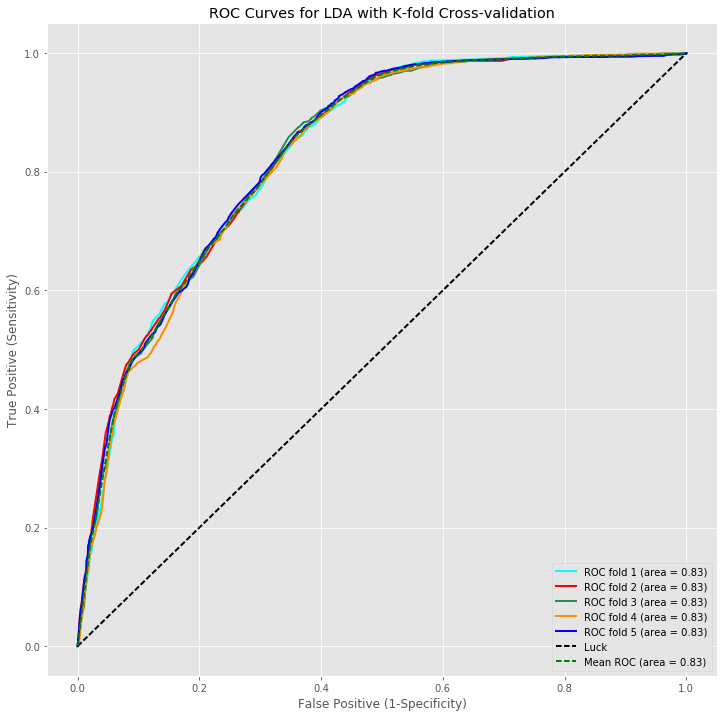

Excel file was saved to: lda-cms.csv
Confusion matrix image was saved to: lda-best-tp-cm.png


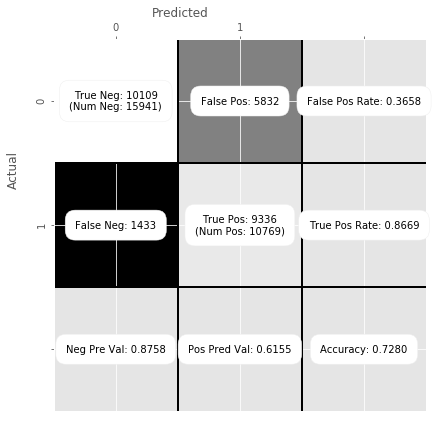

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Brown_White,ColorCat_Other,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,Adopted,Prob_0,Prob_1,Predicted
26705,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.172275,0.827725,1
26706,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.604530,0.395470,0
26707,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.140092,0.859908,1
26708,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.648800,0.351200,0
26709,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.555138,0.444862,0


In [11]:
# Run LDA with cross-validation and plot ROC curves
def fit_lda():
    """
    Fit a model with Linear Discriminant Analysis (LDA).
    """
    # Estimate priors.
    gnb = GaussianNB()
    gnb.fit(X, y)
    priors = gnb.class_prior_

    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = []
    cm_folds = []
    lda_actual = []
    lda_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    predicted_data = []

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train LDA on training dataset
        lda = LinearDiscriminantAnalysis(solver=LDA_SOLVER, priors=priors, 
                                         shrinkage=LDA_SHRINKAGE, store_covariance=True).fit(train_X, train_y)
        # test LDA on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = lda.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = lda.predict(test_X)
        train_predicted = lda.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        lda_actual.extend(test_actual)
        lda_prob.extend(prob)
        roc_kfolds.append([tpr, fpr])
        best_tpr, best_fpr, best_cutoff = u.Utilities.get_best_cutoff(actual=test_actual, prob=prob)
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))
        
        predicted_data.extend(u.Utilities.combine(prob, test_X, test_actual, predicted))

        i += 1
        #/for (train, test)...

    best_mean_tpr /= float(NUM_CV)
    best_mean_fpr /= float(NUM_CV)
    best_mean_cutoff /= float(NUM_CV)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, 1-best_mean_fpr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.Utilities.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation', 2, 'lda-roc')

    if OUTPUT_TO_CSV:
        u.Utilities.output_cms('lda-cms', cm_folds, 'LDA_Test_Folds') # output to CSV

    # Display Confustion Matrix, output to PNG
    best_tp = u.Utilities.get_confusion_matrix(best_mean_cutoff, lda_actual, lda_prob)
    
    # Display Confustion Matrix, output to PNG
    u.Utilities.show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'lda-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(significant_features), np.asarray([TARGET_NAME, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    df.to_csv(OUTPUT_DIR + 'lda-validation.csv')
    display(df.tail())
    
if __name__ == '__main__':
    fit_lda()

### Figure 5.1

Fold 1, TPR: 0.87419, TNR: 0.62120, Cutoff: 0.38000
Fold 2, TPR: 0.86583, TNR: 0.63959, Cutoff: 0.42000
Fold 3, TPR: 0.87465, TNR: 0.63802, Cutoff: 0.42000
Fold 4, TPR: 0.87465, TNR: 0.62547, Cutoff: 0.38000
Fold 5, TPR: 0.85973, TNR: 0.64398, Cutoff: 0.41000
Means:  TPR: 0.86981, TNR: 0.63365, Cutoff: 0.40200
ROC image was saved to: logit-roc.png


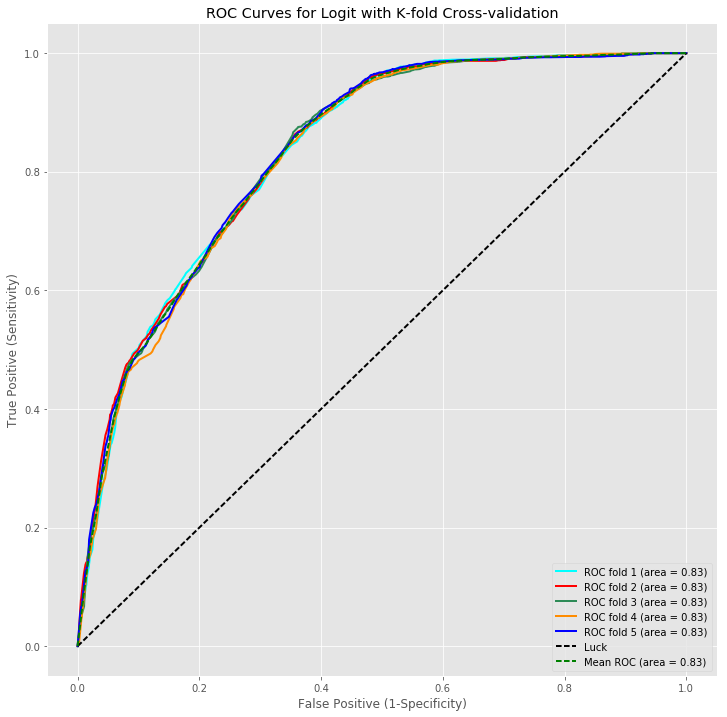

Excel file was saved to: logit-cms.csv
Confusion matrix image was saved to: logit-best-tp-cm.png


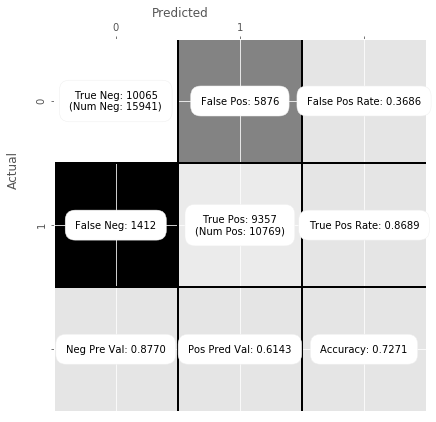

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Brown_White,ColorCat_Other,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,Adopted,Prob_0,Prob_1,Predicted
26705,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.200721,0.799279,1
26706,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.604582,0.395418,0
26707,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.168315,0.831685,1
26708,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.641374,0.358626,0
26709,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.550558,0.449442,0


In [12]:
# Run logistic Regression with cross-validation and plot ROC curves
# Logit can use categorical variaables. Append to cols and get new data set
def fit_logit():
    """
    Fit a model with Logistic Regression.
    """
    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand) # split into N folds
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = [] # store TPR and FPR for each iteration and plot to ROC curve
    cm_folds = []
    logit_actual = []
    logit_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    predicted_data = []

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train Logit on training dataset
        logit = LogisticRegression()
        logit.fit(train_X, train_y)

        # test Logit on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = logit.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = logit.predict(test_X)
        train_predicted = logit.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
        
        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        logit_actual.extend(test_actual)
        logit_prob.extend(prob)
        
        best_tpr, best_fpr, best_cutoff = u.Utilities.get_best_cutoff(actual=test_actual, prob=prob)
        
        roc_kfolds.append([tpr, fpr])
        
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))
    
        # Collect test set into combined table
        predicted_data.extend(u.Utilities.combine(prob, test_X, test_actual, predicted))
        
        i += 1
    #/for (train, test)...

    best_mean_tpr /= float(NUM_CV)
    best_mean_fpr /= float(NUM_CV)
    best_mean_cutoff /= float(NUM_CV)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, 1-best_mean_fpr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.Utilities.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, 'logit-roc')

    if OUTPUT_TO_CSV:
        u.Utilities.output_cms('logit-cms', cm_folds, 'Logit_Test_Folds') # output to excel

    # Display Confustion Matrix, output to PNG
    best_tp = u.Utilities.get_confusion_matrix(best_mean_cutoff, logit_actual, logit_prob)
    u.Utilities.show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'logit-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(significant_features), np.asarray([TARGET_NAME, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    df.to_csv(OUTPUT_DIR + 'logit-validation.csv')
    display(df.tail())
    
if __name__ == '__main__':
    fit_logit()

### Figure 6.0 - JMP Model

<img src="https://raw.githubusercontent.com/jbonfardeci/austin-animal-shelter-model/master/jmp_roc.png" alt="JMP ROC" />
<div>
<table>
    <thead>
        <tr>
            <th>Adopted</th>
            <th>1</th>
            <th>0</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>1</td><td>7228</td><td>3541</td></tr>
        <tr><td>0</td><td>2992</td><td>12968</td></tr>
    </tbody
</table>
</div>
<br /><br />
<p>AUC = <strong>0.83431</strong></p>
<p>Sensitivity = TP / (TP + FN) = 7228 / (7228 + 2992) = <strong>70.72%</strong></p>
<p>Specificity = TN / (TN + FP) = 12968 / (12968 + 3541) = <strong>78.55%</strong></p>
<p>Precision = TP / (TP + FP) = 7228 / (7228 + 3541) = <strong>67.12%</strong></p>